# Exploring the Data

This notebook explores how to import data from the LFW data set. It uses a small sample of the full data set (pictures of George W. Bush).
* [Link to LFW page](http://vis-www.cs.umass.edu/lfw/)
* [Link to GWB data](http://vis-www.cs.umass.edu/lfw/lfw-bush.tgz)
* [Link to lfw-fuel](https://github.com/dribnet/lfw_fuel/blob/master/lfw_fuel/lfw.py) (extremely useful for understanding how to extract data from the images)
* [Link to run-lfw](https://github.com/dribnet/lfw_fuel/blob/master/example/run-lfw.py) (builds a neural network using keras)

In [24]:
# numerics
import numpy as np
import itertools

# images
from scipy.misc import *
#imresize, imread, imshow
import matplotlib.pylab as plt

# dealing with tar files
import tarfile, gzip

# extracting data about faces/people
import csv

# nice stuff
import os, re
from pprint import pprint

In [25]:
%matplotlib inline

Load training and testing data sets (text files provided by LFW):

In [26]:
print("Building test/train lists...")

# skip row 0, which is the header
with open('data/pairsDevTrain.txt', 'r') as csvfile:
    trainrows = list(csv.reader(csvfile, delimiter='\t'))[1:]
with open('data/pairsDevTest.txt', 'r') as csvfile:
    testrows = list(csv.reader(csvfile, delimiter='\t'))[1:]

print("Done.")

Building test/train lists...
Done.


In [27]:
print("Length of training data set: %d"%(len(trainrows)))

Length of training data set: 2200


Here's the explanation of what's going on:
* Each row of trainrows is a training data point (obviously).
* The row gives names and an integer indicating which photo of the person is being used for the training data point.
* If there is a single name and two integers, it means these are pictures of the same person. So `[Aaron_Peirsol, 1, 2]` means the first training data point is Picture #1 and Picture #2 of Aaron Peirsol.
* If there are two names and two integers, it means we are looking at two different people. So `[Tammy_Helm, 1, Taufik_Kieman, 1]` means we are looking at Picture #1 of Tammy Helm and Picture #1 of Taufik Kieman.

The beginning of the training rows show all the instances of *positive* results (yes, we are looking at two images of the same person).

In [28]:
pprint(trainrows[:10])

[['Aaron_Peirsol', '1', '2'],
 ['Aaron_Peirsol', '3', '4'],
 ['Aaron_Sorkin', '1', '2'],
 ['Abdel_Nasser_Assidi', '1', '2'],
 ['Abdullah', '1', '3'],
 ['Abdullah', '2', '4'],
 ['Abdullah_al-Attiyah', '1', '3'],
 ['Abdullah_al-Attiyah', '2', '3'],
 ['Abel_Pacheco', '1', '4'],
 ['Abel_Pacheco', '3', '4']]


The end of the training rows show all the instances of *negative* results (no, we are not looking at two images of the same person).

In [29]:
pprint(trainrows[-10:])

[['Tammy_Helm', '1', 'Taufik_Kiemas', '1'],
 ['Terje_Roed-Larsen', '2', 'Thomas_Rupprath', '3'],
 ['Thomas_Rupprath', '3', 'Wendy_Kennedy', '1'],
 ['Tim_Howard', '1', 'Tom_Reilly', '1'],
 ['Tom_Craddick', '3', 'Val_Ackerman', '1'],
 ['Tom_Vilsack', '1', 'Wayne_Ferreira', '5'],
 ['Trisha_Meili', '1', 'Vladimiro_Montesinos', '3'],
 ['Ty_Votaw', '1', 'Wayne_Allard', '1'],
 ['Vytas_Danelius', '1', 'Zaini_Abdullah', '1'],
 ['Wendy_Kennedy', '1', 'Zara_Akhmadova', '1']]


In [30]:
print("Length of test data set: %d"%(len(testrows)))

Length of test data set: 1000


Same schema as before: the beginning of the test data set lists a single name and two integers, indicating we are looking at the same person, and which photos of that person we are looking at.

In [31]:
pprint(testrows[:10])

[['Abdullah_Gul', '13', '14'],
 ['Abdullah_Gul', '13', '16'],
 ['Abdullatif_Sener', '1', '2'],
 ['Adel_Al-Jubeir', '1', '3'],
 ['Al_Pacino', '1', '2'],
 ['Alan_Greenspan', '1', '5'],
 ['Albert_Costa', '2', '6'],
 ['Albert_Costa', '4', '6'],
 ['Albert_Costa', '5', '6'],
 ['Alejandro_Atchugarry', '1', '2']]


The end of the test data set lists two names and two integers, indicating we are looking at two different people and which of their photos we are looking at.

In [32]:
pprint(testrows[-10:])

[['Shane_Mosley', '1', 'Stacey_Dales-Schuman', '1'],
 ['Sheila_Taormina', '1', 'Stephan_Eberharter', '1'],
 ['Stefano_Gabbana', '1', 'Tang_Jiaxuan', '3'],
 ['Steve_Wariner', '1', 'Toshi_Izawa', '1'],
 ['Steve_Zahn', '1', 'Tab_Baldwin', '1'],
 ['Susan_Whelan', '1', 'Wolfgang_Schneiderhan', '1'],
 ['Takeo_Fukui', '1', 'Will_Ofenheusle', '1'],
 ['Tamara_Mowry', '1', 'Zach_Parise', '1'],
 ['Tatiana_Kennedy_Schlossberg', '1', 'Thomas_Watjen', '1'],
 ['Todd_Petit', '1', 'Vicente_Fernandez', '3']]


The training and test sets have pairs of images that are of the same person (beginning of the file, one name and two numbered images) and pairs of images that are of different people (end of the file, two names and two numbered images).

Next, we show how to load an image from a compressed .tgz file. First, look through all names and check the spelling of George W. Bush:

In [33]:
with open('data/lfw-names.txt', 'r') as csvfile:
    allrows = list(csv.reader(csvfile, delimiter='\t'))[1:]

for row in allrows:
    if('Bush' in row[0]):
        print(row)

['Columba_Bush', '1']
['George_HW_Bush', '13']
['George_P_Bush', '2']
['George_W_Bush', '530']
['Jeb_Bush', '12']
['Laura_Bush', '41']
['Noelle_Bush', '4']


In [34]:
def load_image(tgz_file, basename, name, number):
    
    # images of people are stored in the tar files in the following format:
    # 
    # <basename>/<name>/<name>_<number 04d>.jpg
    #
    # where number comes from the second or third column in the text file
    
    filename = "{0}/{1}/{1}_{2:04d}.jpg".format(basename, name, int(number))
    tgz = tarfile.open(tgz_file)
    return imread(tgz.extractfile(filename))

In [35]:
# From the tarfile of all images of George W. Bush,
tgz = "data/lfw-bush.tgz"

# Load the fifth image:
z = load_image(tgz,"lfw","George_W_Bush",5)

In [36]:
print("Shape of image: W x H x RGB")
print(np.shape(z))

Shape of image: W x H x RGB
(250, 250, 3)


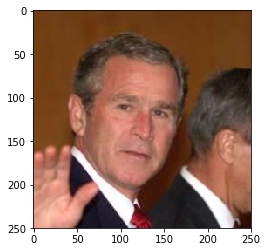

In [37]:
# To show the image in color, 
# convert data z to numpy unsigned 8-bit integer 
# (8 bits = 2^8 = 256 = 0 to 255
plt.imshow(np.uint8(z))

Now turn the image into numbers to feed to the neural network:

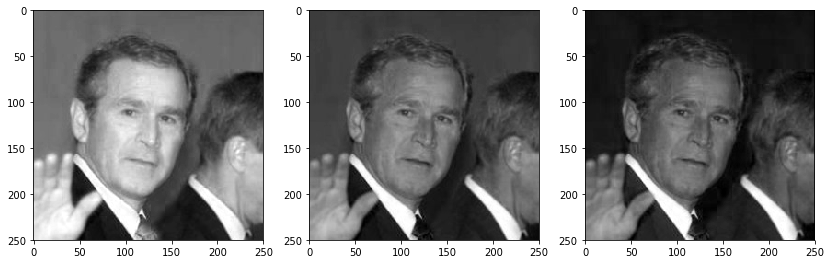

In [45]:
fig = plt.figure(figsize=(14,6))
[ax1, ax2, ax3] = [fig.add_subplot(1,3,i+1) for i in range(3)]

ax1.imshow(z[:,:,0],cmap="gray")
ax2.imshow(z[:,:,1],cmap="gray")
ax3.imshow(z[:,:,2],cmap="gray")
plt.show()

In [46]:
def extract_features(z):
    features = np.array([z[:,:,0],z[:,:,1],z[:,:,2]])
    return features

features = extract_features(z)
print(np.shape(features))

(3, 250, 250)


In [47]:
print(features)

[[[112 114 115 ..., 100 100 100]
  [112 114 115 ..., 101 101 101]
  [112 114 114 ..., 101 101 101]
  ..., 
  [231 231 231 ...,  44  46  46]
  [231 233 234 ...,  46  46  46]
  [232 234 235 ...,  46  46  46]]

 [[ 60  61  62 ...,  55  55  55]
  [ 60  61  62 ...,  56  56  56]
  [ 60  61  61 ...,  56  56  56]
  ..., 
  [155 155 154 ...,   7   9   9]
  [155 157 157 ...,   9   9   9]
  [154 156 157 ...,   9   9   9]]

 [[ 20  19  20 ...,  14  14  14]
  [ 20  19  20 ...,  15  15  15]
  [ 20  19  19 ...,  15  15  15]
  ..., 
  [132 132 134 ...,   1   3   3]
  [132 134 137 ...,   3   3   3]
  [132 134 137 ...,   3   3   3]]]


To train the neural network, we want to iterate through lines of the training set text file. For each line of the training set text file, we grab the two corresponding images. 

For two images of the same person, the line from the training set text file will have three tokens (the name, the first image number, and the second image number).

For two images of different people, the line from the training set text file will have four tokens (the first name, the first image number, the second name, and the second image number).

In [48]:
# Loading "same person" row
pprint(trainrows[0])

['Aaron_Peirsol', '1', '2']


In [49]:
tgz = "data/lfw.tgz"
prefix = "lfw"

def load_one_person(row):
    name = row[0]
    
    imgnum1 = row[1]
    img1 = load_image(tgz, prefix, name, imgnum1)
    
    imgnum2 = row[2]
    img2 = load_image(tgz, prefix, name, imgnum2)
    
    return img1, img2

img1, img2 = load_one_person(trainrows[0])

Make sure we loaded the images okay:

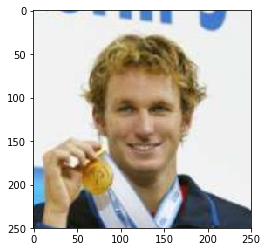

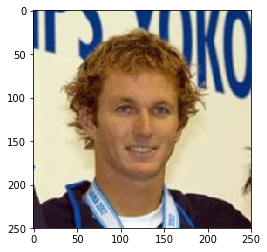

In [50]:
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

In [51]:
# Loading "different person" row
pprint(trainrows[-3])

['Ty_Votaw', '1', 'Wayne_Allard', '1']


In [52]:
tgz = "data/lfw.tgz"
prefix = "lfw"

def load_two_persons(row):
    name1 = row[0]
    imgnum1 = row[1]
    img1 = load_image(tgz, prefix, name1, imgnum1)
    
    name2 = row[2]
    imgnum2 = row[3]
    img2 = load_image(tgz, prefix, name2, imgnum2)
    
    return img1, img2

img1, img2 = load_two_persons(trainrows[-3])

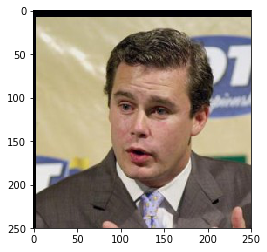

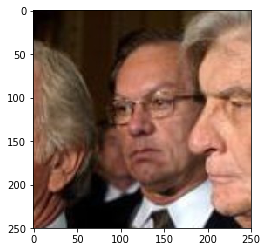

In [53]:
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

In [54]:
print(np.shape(img1))

(250, 250, 3)


np.ravel, which makes everything 1D, may be useful, or maybe not.

In [55]:
print(np.shape(np.ravel(img1)))

(187500,)


What we really want is to write a function to load the data where we can say something like this:

```
(X_train, Y_train), (X_test, Y_test) = lfw.load_data()
```

Then, if you want to apply any transforms to the input data, you can do so:

```
X_train = np.asarray(map(transformFunction, X_train))
X_test  = np.asarray(map(transformFunction, X_test))
```

In [56]:
# Iterator over ALL rows.
# Function to combine getting one person or getting two persons, dynamically.
# Function to get "category" - either 0 or 1 - depending on row size.

In [57]:
'''
batch_size = 128
nb_classes = 2
nb_epoch = 12
feature_width = 32
feature_height = 32

def cropImage(im):
    im2 = np.dstack(im).astype(np.uint8)
    # return centered 128x128 from original 250x250 (40% of area)
    newim = im2[61:189, 61:189]
    sized1 = imresize(newim[:,:,0:3], (feature_width, feature_height), interp="bicubic", mode="RGB")
    sized2 = imresize(newim[:,:,3:6], (feature_width, feature_height), interp="bicubic", mode="RGB")
    return np.asarray([sized1[:,:,0], sized1[:,:,1], sized1[:,:,2], sized2[:,:,0], sized2[:,:,1], sized2[:,:,2]])

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = lfw.load_data("deepfunneled")
# crop features
X_train = np.asarray(map(cropImage, X_train))
X_test = np.asarray(map(cropImage, X_test))
'''

'\nbatch_size = 128\nnb_classes = 2\nnb_epoch = 12\nfeature_width = 32\nfeature_height = 32\n\ndef cropImage(im):\n    im2 = np.dstack(im).astype(np.uint8)\n    # return centered 128x128 from original 250x250 (40% of area)\n    newim = im2[61:189, 61:189]\n    sized1 = imresize(newim[:,:,0:3], (feature_width, feature_height), interp="bicubic", mode="RGB")\n    sized2 = imresize(newim[:,:,3:6], (feature_width, feature_height), interp="bicubic", mode="RGB")\n    return np.asarray([sized1[:,:,0], sized1[:,:,1], sized1[:,:,2], sized2[:,:,0], sized2[:,:,1], sized2[:,:,2]])\n\n# the data, shuffled and split between train and test sets\n(X_train, y_train), (X_test, y_test) = lfw.load_data("deepfunneled")\n# crop features\nX_train = np.asarray(map(cropImage, X_train))\nX_test = np.asarray(map(cropImage, X_test))\n'

In [58]:
a = [np.zeros([10,10,3]) for n in range(20)]
b = np.array([  [[f[:,:,0], f[:,:,1], f[:,:,2]]] for f in a])
print(b)

[[[[[ 0.  0.  0. ...,  0.  0.  0.]
    [ 0.  0.  0. ...,  0.  0.  0.]
    [ 0.  0.  0. ...,  0.  0.  0.]
    ..., 
    [ 0.  0.  0. ...,  0.  0.  0.]
    [ 0.  0.  0. ...,  0.  0.  0.]
    [ 0.  0.  0. ...,  0.  0.  0.]]

   [[ 0.  0.  0. ...,  0.  0.  0.]
    [ 0.  0.  0. ...,  0.  0.  0.]
    [ 0.  0.  0. ...,  0.  0.  0.]
    ..., 
    [ 0.  0.  0. ...,  0.  0.  0.]
    [ 0.  0.  0. ...,  0.  0.  0.]
    [ 0.  0.  0. ...,  0.  0.  0.]]

   [[ 0.  0.  0. ...,  0.  0.  0.]
    [ 0.  0.  0. ...,  0.  0.  0.]
    [ 0.  0.  0. ...,  0.  0.  0.]
    ..., 
    [ 0.  0.  0. ...,  0.  0.  0.]
    [ 0.  0.  0. ...,  0.  0.  0.]
    [ 0.  0.  0. ...,  0.  0.  0.]]]]



 [[[[ 0.  0.  0. ...,  0.  0.  0.]
    [ 0.  0.  0. ...,  0.  0.  0.]
    [ 0.  0.  0. ...,  0.  0.  0.]
    ..., 
    [ 0.  0.  0. ...,  0.  0.  0.]
    [ 0.  0.  0. ...,  0.  0.  0.]
    [ 0.  0.  0. ...,  0.  0.  0.]]

   [[ 0.  0.  0. ...,  0.  0.  0.]
    [ 0.  0.  0. ...,  0.  0.  0.]
    [ 0.  0.  0. ...,  0.  0.  0.]
   